# MiniRun6 LRS tutorial 1

In [2]:
import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm, colors
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm
from matplotlib import colors, ticker
import itertools

!pip install ./h5flow
from h5flow.data import dereference
from proto_nd_flow.util.lut import LUT

Processing ./h5flow
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for h5flow: filename=h5flow-0.2.4-py3-none-any.whl size=31716 sha256=ae98a99ead14d3380e3ddeebdbfc4571c4fd7add1d213cea79e709c1436551cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-3mwf84ug/wheels/f1/5d/58/77983378fc64f41b62b695d5a44d952fa4c38d69af5c3ba1f2
Successfully built h5flow
  Attempting uninstall: h5flow
    Found existing installation: h5flow 0.2.4
    Uninstalling h5flow-0.2.4:
      Successfully uninstalled h5flow-0.2.4


Hello


## Import ndlar_flow file

In [3]:
fname = '/global/cfs/cdirs/dune/www/data/2x2/reflows/v11/flow/beam/july10_2024/nominal_hv/packet-0050018-2024_07_10_12_56_35_CDT.FLOW.hdf5'
f = h5py.File(fname)

In [4]:
def h5_tree(val, pre='',skip_ref=False):
    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if type(val) == h5py._hl.group.Group:
                print(pre + '└── ' + key)
                if key=="ref" and skip_ref:
                    continue
                h5_tree(val, pre+'    ')
            else:
                print(pre + '└── ' + key + ' (%d)' % len(val))
        else:
            if type(val) == h5py._hl.group.Group:
                print(pre + '├── ' + key)
                h5_tree(val, pre+'│   ')
            else:
                print(pre + '├── ' + key + ' (%d)' % len(val))

In [5]:
h5_tree(f)

├── charge
│   ├── calib_final_hits
│   │   ├── data (744979)
│   │   └── ref
│   │       └── charge
│   │           ├── calib_prompt_hits
│   │           │   └── ref_region (744979)
│   │           ├── events
│   │           │   └── ref_region (744979)
│   │           └── raw_events
│   │               └── ref_region (744979)
│   ├── calib_prompt_hits
│   │   ├── data (1722413)
│   │   └── ref
│   │       └── charge
│   │           ├── calib_final_hits
│   │           │   ├── ref (744979)
│   │           │   └── ref_region (1722413)
│   │           ├── events
│   │           │   └── ref_region (1722413)
│   │           ├── packets
│   │           │   ├── ref (1722413)
│   │           │   └── ref_region (1722413)
│   │           └── raw_events
│   │               └── ref_region (1722413)
│   ├── events
│   │   ├── data (9991)
│   │   └── ref
│   │       ├── charge
│   │       │   ├── calib_final_hits
│   │       │   │   ├── ref (744979)
│   │       │   │   └── ref_region (9991)
│   │  

In [6]:
h5_tree(f["geometry_info"])

├── anode_drift_coordinate
│   └── data (257)
├── det_bounds
│   └── data (129)
├── det_id
│   └── data (481)
├── det_rel_pos
│   └── data (129)
├── det_type
│   └── data (129)
├── disabled_channels
│   └── data (0)
├── disabled_chips
│   └── data (0)
├── drift_dir
│   └── data (257)
├── pixel_coordinates_2D
│   └── data (1638401)
├── sipm_abs_pos
│   └── data (481)
├── sipm_rel_pos
│   └── data (481)
└── tile_id
    └── data (4097)


/tmp/ipykernel_2077971/3493514221.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')  # discrete colormap with 4 colors


Channel Status Shape: (8, 64)


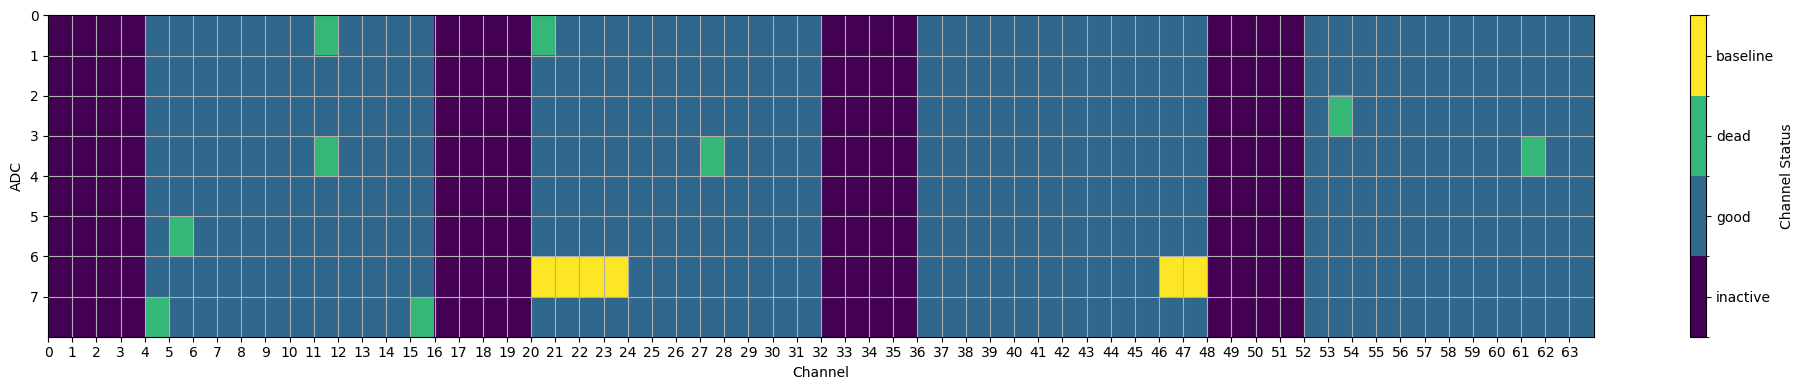

In [7]:
# load csv generated in lrs_sanity_check from yaml file proto_nd_flow
channel_status = pd.read_csv('/global/homes/j/jvmead/dune/lrs_sanity_check/channel_status/channel_status.csv', header=None).to_numpy()
print('Channel Status Shape:', np.shape(channel_status))

# define figure
figure = plt.figure(figsize=(20,4))
ax = figure.add_subplot(111)
cmap = cm.get_cmap('viridis')  # discrete colormap with 4 colors
ax.imshow(channel_status, cmap=cmap, aspect='auto')

# Define discrete intervals
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]
norm = BoundaryNorm(bounds, ncolors=256)

# Create the colorbar with discrete intervals
cbar = plt.colorbar(ax.imshow(channel_status, cmap=cmap, norm=norm,
                              aspect='auto'), ticks=[-1, 0, 1, 2])
cbar.ax.set_yticklabels(['inactive', 'good', 'dead', 'baseline'])
cbar.set_label('Channel Status')

# gridlines
ax.set_xticks(np.arange(0, 64, 1)-0.5)
ax.set_yticks(np.arange(0, 8, 1)-0.5)
ax.set_xticklabels(np.arange(0, 64, 1))
ax.set_yticklabels(np.arange(0, 8, 1))
plt.xlabel('Channel')
plt.ylabel('ADC')

plt.tight_layout()
plt.grid()
plt.show()

In [8]:
def plot_metric(
    metric,
    channel_status=None,
    log_scale=False,
    exclude_bad=True,
    exclude_inactive=False,
    ylabel='ADC counts',
    title=None
):
  # set up figure
  fig, ax = plt.subplots(figsize=(20, 4))
  # Mask bad channels if requested
  if channel_status is not None and exclude_bad:
    metric_plot = np.ma.masked_where(channel_status != 0, metric)
  elif channel_status is not None and exclude_inactive:
    metric_plot = np.ma.masked_where(channel_status == -1, metric)
  else:
    metric_plot = metric
  # Choose colormap and normalization
  cmap = plt.cm.get_cmap('viridis').copy()
  cmap.set_bad(color='white')
  if log_scale:
    norm = colors.LogNorm(np.nanmin(metric_plot[metric_plot > 0]),
                np.nanmax(metric_plot))
  else:
    norm = colors.Normalize()
  im = ax.imshow(metric_plot, cmap=cmap, norm=norm, aspect='auto')
  plt.colorbar(im, ax=ax, label=ylabel)
  # Gridlines and labels
  ax.set_xticks(np.arange(0, 64, 1) - 0.5)
  ax.set_yticks(np.arange(0, 8, 1) - 0.5)
  ax.set_xticklabels(np.arange(0, 64, 1))
  ax.set_yticklabels(np.arange(0, 8, 1))
  plt.xlabel('Channel')
  plt.ylabel('ADC')
  plt.grid(which='both', linewidth=0.5, alpha=0.5, color='white')
  plt.tight_layout()
  plt.title(title)
  # Overlay red circles for bad channels if not excluded
  if channel_status is not None and not exclude_bad:
    bad_idx = np.where(channel_status > 0)
    for y, x in zip(*bad_idx):
      ax.scatter(x, y, s=200, c='red', marker='o', edgecolors='none', zorder=10)
  plt.show()

(8, 64)


/tmp/ipykernel_2077971/2585556046.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis').copy()


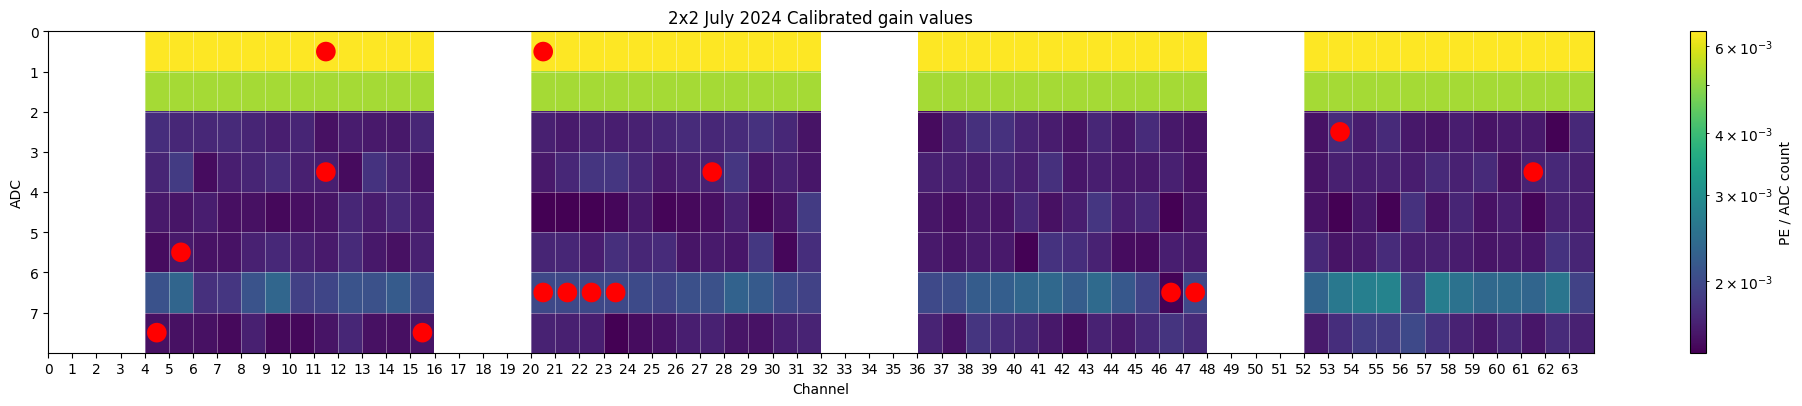

In [9]:
# load calibration csv as df
path = '/global/homes/j/jvmead/dune/lrs_sanity_check/calibration/data_calib.csv'
calib = pd.read_csv(path, header=None).to_numpy()
print(calib.shape)


# plot height to calibration
plot_metric(calib, channel_status=channel_status, log_scale=True,
            exclude_bad=False, exclude_inactive=True, ylabel='PE / ADC count',
            title='2x2 July 2024 Calibrated gain values')

In [10]:
max_events = 100
events = np.linspace(0,max_events,max_events+1,dtype=int)

# dividing by 4 because the raw wvfms are stored in 16 bit register
light_wvfms = f['light/wvfm/data/']['samples'][events]/4.0
print(light_wvfms.shape)

sipm_hits = f['light/sipm_hits/data']
print(sipm_hits.dtype.names)
print(sipm_hits.shape)

(101, 8, 64, 1000)
('id', 'adc', 'chan', 'pos', 'sample_idx', 'ns', 'busy_ns', 'samples', 'sum', 'max', 'sum_spline', 'max_spline', 'ns_spline', 'rising_spline', 'rising_err_spline', 'fwhm_spline')
(112327,)


In [11]:
# get min_range_baseline from ndlar_flow.proto_nd_flow.reco.light.assertwvfm_noise_filter
# https://github.com/DUNE/ndlar_flow/blob/11ff23d46d5071cbd2618a12112d8db01903f72e/src/proto_nd_flow/reco/light/wvfm_noise_filter.py#L97-L123
def min_range_baseline(array, segment_size=25, num_segments=40, num_means=4):

    # Define start and end indices for segments
    indices = np.arange(num_segments + 1) * segment_size  # (41,)
    start_indices, end_indices = indices[:-1], indices[1:]  # (40,)

    # Generate index array for advanced indexing
    segment_range = np.arange(segment_size)  # (25,)
    index_array = start_indices[:, None] + segment_range  # Shape: (40, 25)

    # Extract data from segments using indexing
    sliced_data = array[..., index_array]  # Shape (..., 40, 25)

    # Compute range (peak-to-peak difference) and mean for each segment
    ranges = np.abs(np.ptp(sliced_data, axis=-1))  # Shape (..., 40)
    means = np.mean(sliced_data, axis=-1)  # Shape (..., 40)

    # Mask zero ranges
    mask_zero = (ranges != 0)
    ranges = np.where(mask_zero, ranges, np.nan)
    means = np.where(mask_zero, means, np.nan)

    # Find the ordering of the segments based on the smallest range
    smallest_ordering = np.argsort(ranges, axis=-1)  # Shape (..., 40)

    # Sort means according to the ordering of smallest ranges
    sorted_means = np.take_along_axis(means, smallest_ordering, axis=-1)  # Shape (..., 40)

    # Compute the average of the 2nd, 3rd, and 4th smallest means
    average_mean = np.mean(sorted_means[..., 1:num_means], axis=-1)  # Shape (...)

    # calculate RMS for the ranges of the smallest range segments
    rms = np.sqrt(np.mean(np.square(np.take_along_axis(ranges, smallest_ordering[..., :num_means], axis=-1)), axis=-1))

    return average_mean, rms

baselines, rms = min_range_baseline(light_wvfms)
print(baselines.shape)
print(rms.shape)

(101, 8, 64)
(101, 8, 64)


/tmp/ipykernel_2077971/2780919884.py:2: RuntimeWarning: Mean of empty slice
  mean_baseline = np.nanmean(baselines, axis=0)
/tmp/ipykernel_2077971/2585556046.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis').copy()


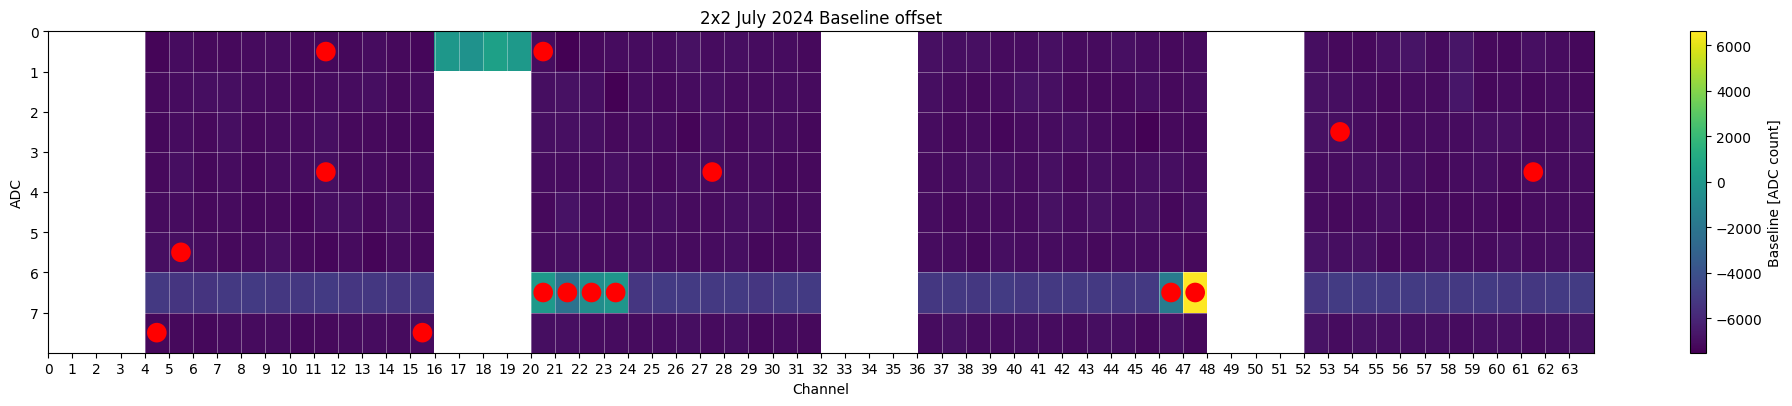

/tmp/ipykernel_2077971/2780919884.py:8: RuntimeWarning: Mean of empty slice
  mean_rms = np.nanmean(rms, axis=0)
/tmp/ipykernel_2077971/2585556046.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis').copy()


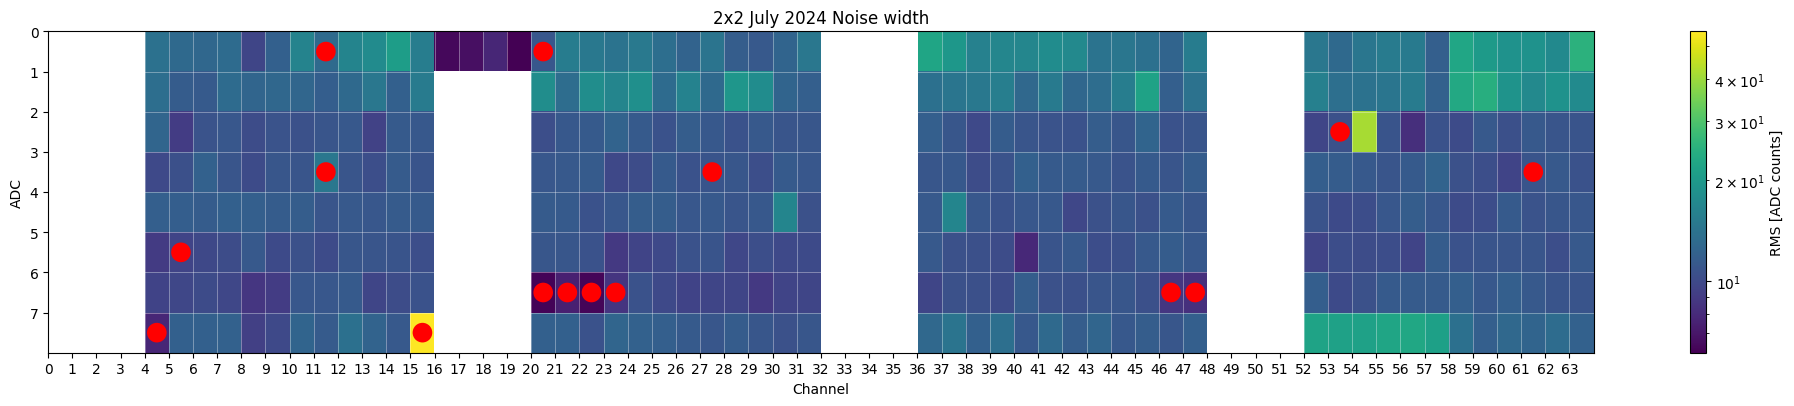

In [12]:
# plot baselines
mean_baseline = np.nanmean(baselines, axis=0)
plot_metric(mean_baseline, channel_status=channel_status, log_scale=False,
            exclude_bad=False, ylabel='Baseline [ADC count]',
            title='2x2 July 2024 Baseline offset')

# plot RMS noise
mean_rms = np.nanmean(rms, axis=0)
plot_metric(mean_rms, channel_status=channel_status, log_scale=True,
            exclude_bad=False, ylabel='RMS [ADC counts]',
            title='2x2 July 2024 Noise width')

In [13]:
def plot_metric_div(
    metric,
    channel_status=None,
    log_scale=False,
    exclude_bad=True,
    mask_inactive=True,
    title='Metric',
    center=None,
    lt=None,
    gt=None,
    cmap='bwr'
):

    # Set up figure
    fig, ax = plt.subplots(figsize=(20, 4))
    # Mask bad channels if requested
    if channel_status is not None and exclude_bad:
        metric = np.ma.masked_where(channel_status != 0, metric)
    # If not excluding, make inactive (-1) NaN so it uses "bad" color; keep bad>0 for overlay
    if channel_status is not None and mask_inactive:
        inactive_idx = np.where(channel_status == -1)
        metric[inactive_idx] = np.nan
    # Colormap / norm
    if cmap == 'rwb':
        # reverse blue-white-red
        cmap = plt.cm.get_cmap('bwr').copy()
        cmap = cmap.reversed()
    cmap = plt.cm.get_cmap(cmap).copy()
    cmap.set_bad('black')  # masked/NaN shown as black for divergent
    # centre of divergence (white)
    if center is None:
        print ("Center not specified, using 0.0")
        center = 0.0
    # Determine a symmetric span about `center` that covers data *and* (if set) the window edges
    data_min = np.nanmin(metric)
    data_max = np.nanmax(metric)
    candidates = [max(0.0, center - data_min), max(0.0, data_max - center)]
    half_span = max(candidates) if candidates else 1.0
    if not np.isfinite(half_span) or half_span <= 0:
        half_span = 1.0
    # log scale with SymLogNorm
    if log_scale:
        # Shift so that white (0 after shift) is at 'center'
        shifted = metric - center
        # Choose a linear threshold for SymLog (smallest nonzero |shifted| with a floor)
        nz = np.abs(shifted)
        nz = nz[nz > 0]
        linthresh = max(np.nanmin(nz) if nz.size else 0.0, half_span * 1e-3)
        norm = colors.SymLogNorm(
            linthresh=linthresh,
            vmin=-half_span,
            vmax=+half_span,
            base=10.0
        )

        im = ax.imshow(shifted, cmap=cmap, norm=norm, aspect='auto')

        # Colorbar shows original (unshifted) values
        cbar = plt.colorbar(im, ax=ax, label=title)
        cbar.formatter = ticker.FuncFormatter(lambda val, pos: f"{val + center:g}")
        cbar.update_ticks()
    else:
        # Linear divergent symmetric scaling
        norm = colors.TwoSlopeNorm(vmin=center - half_span, vcenter=center, vmax=center + half_span)
        im = ax.imshow(metric, cmap=cmap, norm=norm, aspect='auto')
        plt.colorbar(im, ax=ax, label=title)

    # Highlight (on visible data)
    if lt is not None:
        levels = lt if (np.iterable(lt) and not isinstance(lt, str)) else [lt]
        for h in levels:
            yy, xx = np.where((metric < h) & np.isfinite(metric))
            for y, x in zip(yy, xx):
                ax.add_patch(plt.Rectangle((x-0.5, y-0.5), 1, 1,
                                           fill=False, edgecolor='yellow', linewidth=2, zorder=11))
    if gt is not None:
        levels = gt if (np.iterable(gt) and not isinstance(gt, str)) else [gt]
        for h in levels:
            yy, xx = np.where((metric > h) & np.isfinite(metric))
            for y, x in zip(yy, xx):
                ax.add_patch(plt.Rectangle((x-0.5, y-0.5), 1, 1,
                                           fill=False, edgecolor='yellow', linewidth=2, zorder=11))

    # Overlay bad channels if not excluded
    if channel_status is not None and not exclude_bad:
        color = 'k'
        bad_idx = np.where(channel_status > 0)
        for y, x in zip(*bad_idx):
            ax.scatter(x, y, s=100, c=color, marker='o', edgecolors='none', zorder=10)

    # Axes styling
    ax.set_xticks(np.arange(0, 64, 1) - 0.5)
    ax.set_yticks(np.arange(0, 8, 1) - 0.5)
    ax.set_xticklabels(np.arange(0, 64, 1))
    ax.set_yticklabels(np.arange(0, 8, 1))
    plt.xlabel('Channel')
    plt.ylabel('ADC')
    plt.grid(which='both', linewidth=0.5, alpha=0.5, color='white')
    plt.tight_layout()
    plt.title(title)
    plt.show()

/tmp/ipykernel_2077971/550405512.py:4: RuntimeWarning: divide by zero encountered in divide
  plot_metric(spe_height_to_integral/calib, channel_status=channel_status, log_scale=False,
/tmp/ipykernel_2077971/2585556046.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis').copy()


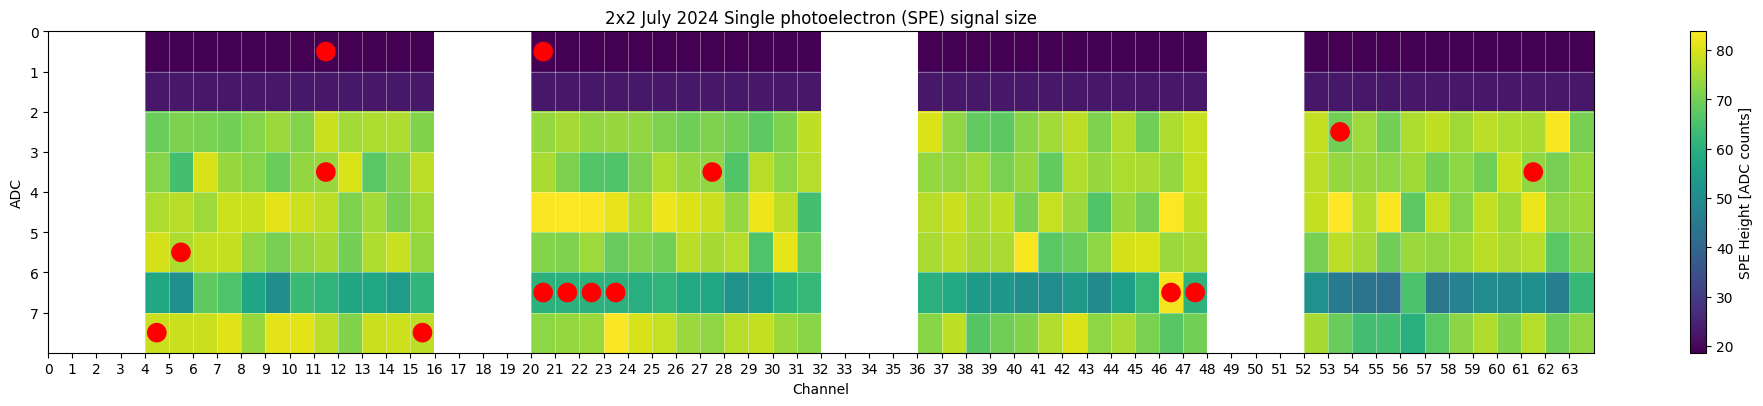

/tmp/ipykernel_2077971/550405512.py:9: RuntimeWarning: divide by zero encountered in divide
  SNR_spe = (spe_height_to_integral/calib)/mean_rms
/tmp/ipykernel_2077971/570452660.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('bwr').copy()
/tmp/ipykernel_2077971/570452660.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap).copy()


SNR (SPE/RMS) Shape: (8, 64)


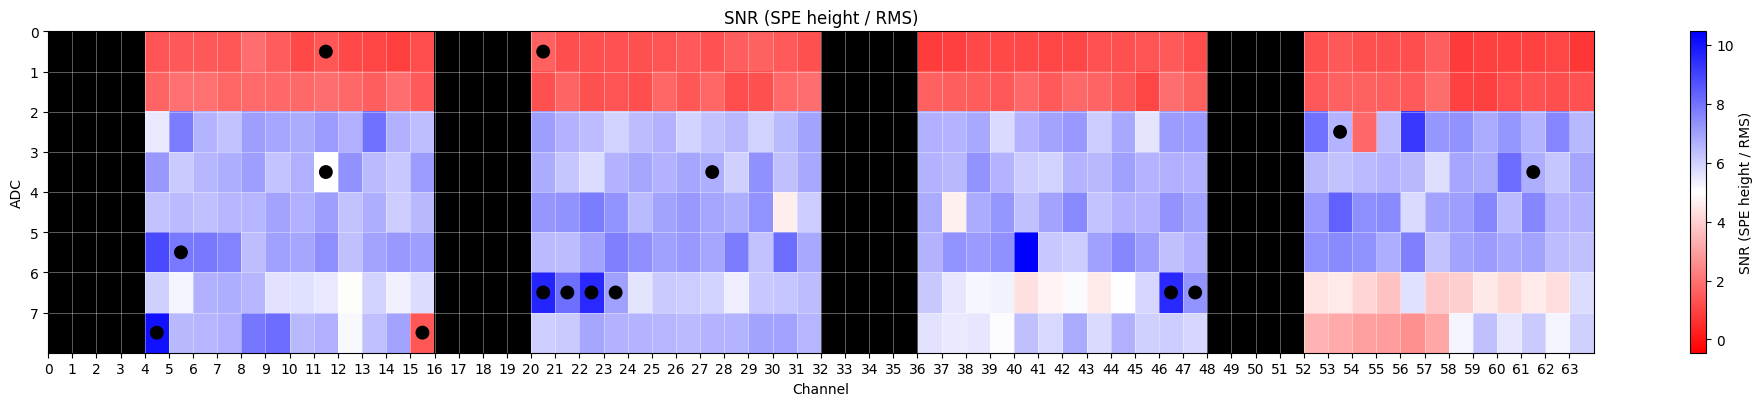

In [14]:
spe_height_to_integral = 0.12

# plot height to SPE height (height_integral_ratio/calibration)
plot_metric(spe_height_to_integral/calib, channel_status=channel_status, log_scale=False,
            exclude_bad=False, exclude_inactive=True, ylabel='SPE Height [ADC counts]',
            title='2x2 July 2024 Single photoelectron (SPE) signal size')

# compute SNR as (SPE height / RMS)
SNR_spe = (spe_height_to_integral/calib)/mean_rms
print('SNR (SPE/RMS) Shape:', np.shape(SNR_spe))

plot_metric_div(SNR_spe,
             channel_status=channel_status,
             log_scale=False,
             exclude_bad=False,
             title="SNR (SPE height / RMS)",
             center=5.0,
             cmap='rwb')

/tmp/ipykernel_2077971/2686042908.py:3: RuntimeWarning: divide by zero encountered in divide
  dynamic_range = (signed_adc_max - mean_baseline) / (spe_height_to_integral/calib)
/tmp/ipykernel_2077971/2585556046.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis').copy()


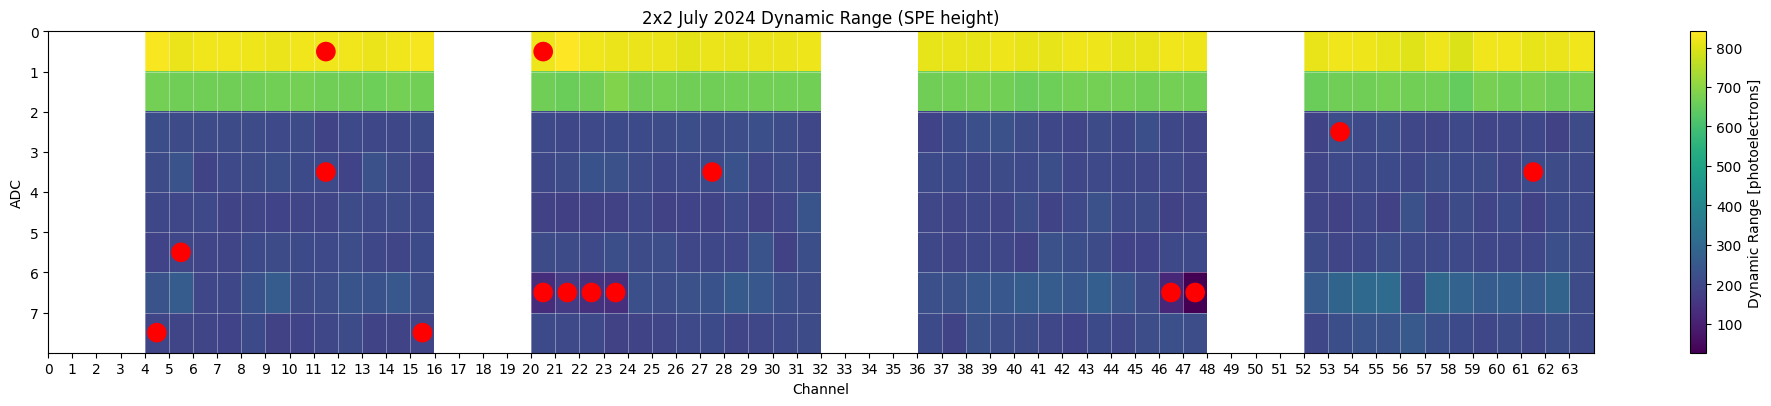

In [17]:
# dynamic range as (max ADC - baseline) / SPE height
signed_adc_max = 2**13 - 1
dynamic_range = (signed_adc_max - mean_baseline) / (spe_height_to_integral/calib)

plot_metric(dynamic_range, channel_status=channel_status, log_scale=False,
            exclude_bad=False, exclude_inactive=True, ylabel='Dynamic Range [photoelectrons]',
            title='2x2 July 2024 Dynamic Range (SPE height)')

/tmp/ipykernel_2077971/2585556046.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis').copy()


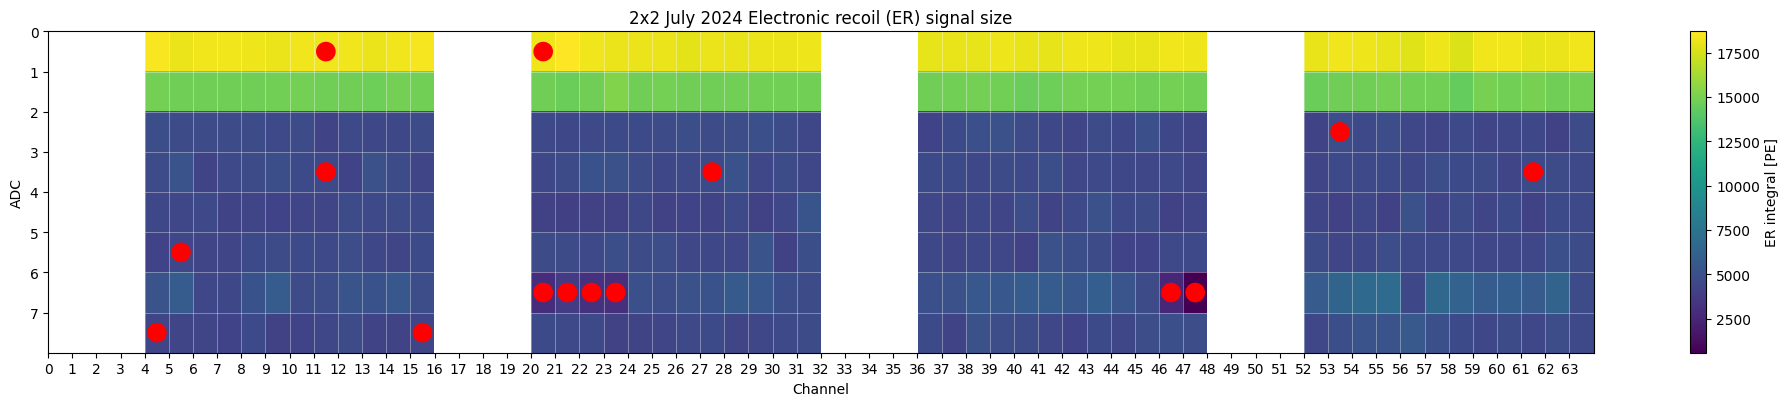

In [21]:
# factor for height to integral ratio for electronic recoil pulse at 62.5MHz
height_to_integral_er = 0.045
plot_metric(dynamic_range/height_to_integral_er, channel_status=channel_status, log_scale=False,
            exclude_bad=False, exclude_inactive=True, ylabel='ER integral [PE]',
            title='2x2 July 2024 Electronic recoil (ER) signal size')

/tmp/ipykernel_2077971/2585556046.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis').copy()


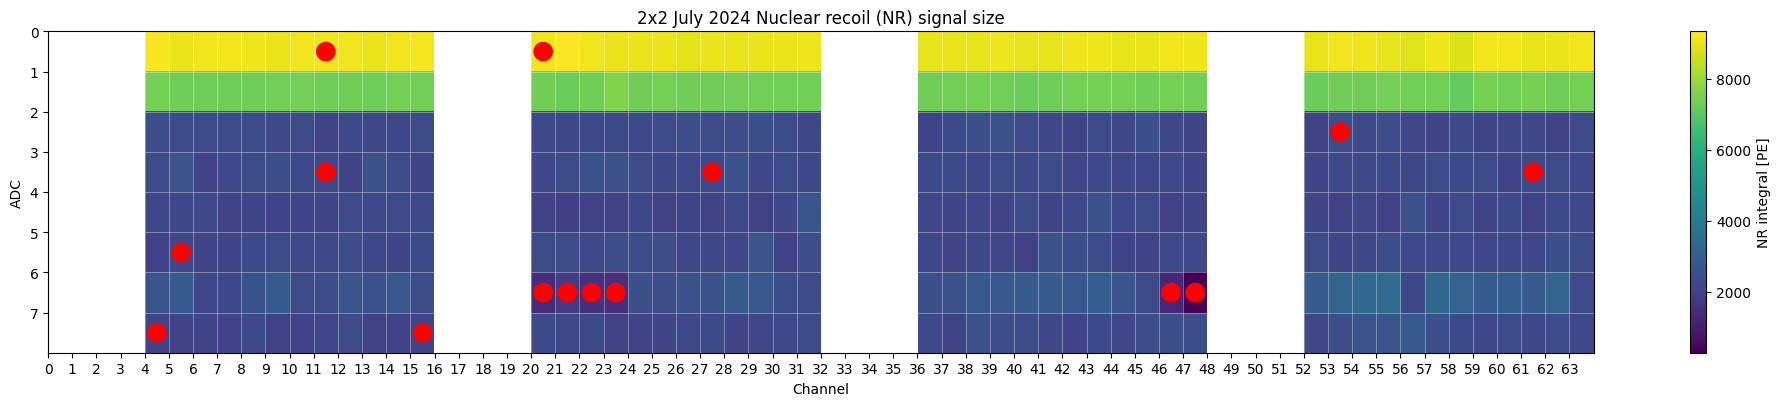

In [22]:
# factor for height to integral ratio for nuclear recoil pulse at 62.5MHz
height_to_integral_nr = 2 * height_to_integral_er
plot_metric(dynamic_range/height_to_integral_nr, channel_status=channel_status, log_scale=False,
            exclude_bad=False, exclude_inactive=True, ylabel='NR integral [PE]',
            title='2x2 July 2024 Nuclear recoil (NR) signal size')